In [1]:
# %% ⸺ Imports & set-up
import math, os, random, time, pathlib
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using", device)

Using mps


In [2]:
# %% ⸺ Hyper-parameters
ROOT_DIR       = "../data/by_degrees"        # path to your 0…359 sub-folders
IMG_SIZE       = 128             # shorter side after resize
BATCH_SIZE     = 64
NUM_EPOCHS     = 50
LR             = 3e-4
VAL_SPLIT      = 0.1             # 10 % held-out validation
SEED           = 42
DEVICE = device
torch.manual_seed(SEED); random.seed(SEED)

In [3]:
# %% ⸺ Transforms
img_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE//2)), # resize to 128x64
    # transforms.CenterCrop(IMG_SIZE),     # images are “vertical rectangles”; crop square centre
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)   # map pixel range to about (-1,1)
])

def angle_to_unitvec(label: int) -> torch.Tensor:
    """label is an int 0…359 coming from ImageFolder"""
    rad = math.radians(label)
    return torch.tensor([math.cos(rad), math.sin(rad)], dtype=torch.float32)

# ImageFolder will give us the int label; target_transform converts it
ds_full = datasets.ImageFolder(ROOT_DIR, transform=img_tf,
                               target_transform=angle_to_unitvec, allow_empty=True)

# train / val split
val_len = int(len(ds_full) * VAL_SPLIT)
train_ds, val_ds = random_split(ds_full, [len(ds_full) - val_len, val_len],
                                generator=torch.Generator().manual_seed(SEED))

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train batches: {len(train_dl)},  Val batches: {len(val_dl)}")

Train batches: 23,  Val batches: 3


In [4]:
# %% ⸺ Model
class CustomCNN(nn.Module):
    """
    A custom convolutional neural network that takes 64x128 images
    and outputs a 2-dimensional vector representing (cos, sin).
    Outputs are normalized to ensure they lie on the unit circle.
    """
    def __init__(self, input_channels: int = 3):
        super(CustomCNN, self).__init__()
        # Feature extractor
        self.features = nn.Sequential(
            # Conv block 1: 3 -> 16, output size: 64x128 -> 32x64
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 2: 16 -> 32, output size: 32x64 -> 16x32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 3: 32 -> 64, output size: 16x32 -> 8x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 4: 64 -> 128, output size: 8x16 -> 4x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier head: flatten and output two values
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 8, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 2),
            # nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, input_channels, 64, 128)
        x = self.features(x)
        x = self.classifier(x)
        # Normalize to unit length for (cos, sin)
        # print(x)
        x = F.normalize(x, p=2, dim=1)
        return x

model = CustomCNN().to(device)
criterion = nn.MSELoss()          # between two (cos, sin) vectors
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [5]:
# from torch.amp import autocast, GradScaler
# scaler     = GradScaler()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [6]:
# %% ⸺ Training / validation helpers
def step(dataloader, train: bool = False):
    model.train(train)
    total_loss, n = 0.0, 0
    for imgs, vec in dataloader:
        imgs, vec = imgs.to(device), vec.to(device)
        
        pred = model(imgs)
        if train:
            opt.zero_grad()
        loss = criterion(pred, vec)
        if train:
            loss.backward(); opt.step()
        bs = imgs.size(0)
        total_loss += loss.item() * bs
        n += bs
    return total_loss / n

def vec2deg(v: torch.Tensor) -> torch.Tensor:
    """v is (N,2) on CPU; returns angles in [0,360)"""
    ang = torch.atan2(v[:,1], v[:,0])   # (-π, π]
    deg = torch.rad2deg(ang) % 360
    return deg

In [7]:
# %% ⸺ Add these helpers somewhere after vec2deg
def angular_error(pred_vec, true_vec):
    """
    pred_vec, true_vec: (B,2) unit vectors on CPU or GPU.
    Returns tensor of shape (B,) containing signed error in degrees in (-180,180].
    """
    pred_deg = vec2deg(pred_vec)
    true_deg = vec2deg(true_vec)
    diff = (pred_deg - true_deg + 180) % 360 - 180
    return diff

def angular_accuracy(pred_vec, true_vec, threshold=0.5):
    """
    Fraction of examples where |error| <= threshold degrees.
    By default threshold=0.5 corresponds to exact nearest-degree match.
    """
    err = angular_error(pred_vec, true_vec).abs()
    return (err <= threshold).float().mean().item()

In [8]:
# %% ⸺ After vec2deg, add RMSAE helper
def rmse_ang(pred_vec, true_vec):
    """
    pred_vec, true_vec: (B,2) unit vectors
    Returns the root-mean-squared angular error in degrees.
    """
    # convert to degrees
    pred_deg = vec2deg(pred_vec)
    true_deg = vec2deg(true_vec)
    # wrap-aware difference in (-180,180]
    diff = (pred_deg - true_deg + 180) % 360 - 180
    # RMS
    return torch.sqrt((diff ** 2).mean()).item()

In [9]:
# %% ⸺ After vec2deg, add MAAE helper
def mae_ang(pred_vec, true_vec):
    """
    pred_vec, true_vec: (B,2) unit vectors
    Returns the mean absolute angular error in degrees.
    """
    # convert to degrees
    pred_deg = vec2deg(pred_vec)
    true_deg = vec2deg(true_vec)
    # wrap-aware difference in (-180,180]
    diff = (pred_deg - true_deg + 180) % 360 - 180
    # Mean absolute error
    return diff.abs().mean().item()

In [10]:
# %% ⸺ Modified training loop to track val_maae
history = {"train_loss": [], "val_loss": [], "val_maae": []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = step(train_dl, train=True)
    
    # validation: loss + MAAE
    model.eval()
    total_val_loss, total_maae, n = 0.0, 0.0, 0
    with torch.no_grad():
        for imgs, true_vec in val_dl:
            imgs, true_vec = imgs.to(device), true_vec.to(device)
            pred_vec = model(imgs)

            # accumulate loss
            total_val_loss += criterion(pred_vec, true_vec).item() * imgs.size(0)
            # compute batch MAAE on CPU
            batch_maae = mae_ang(pred_vec.cpu(), true_vec.cpu())
            total_maae   += batch_maae * imgs.size(0)
            n += imgs.size(0)

    val_loss = total_val_loss / n
    val_maae = total_maae / n

    # record
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_maae"].append(val_maae)

    print(f"Epoch {epoch:2d}/{NUM_EPOCHS}  "
          f"train_loss {train_loss:.4f}  "
          f"val_loss {val_loss:.4f}  "
          f"val_MAAE {val_maae:5.2f}°  ")

Epoch  1/50  train_loss 0.2848  val_loss 0.9017  val_MAAE 83.23°  
Epoch  2/50  train_loss 0.1469  val_loss 0.1268  val_MAAE 19.62°  
Epoch  3/50  train_loss 0.1038  val_loss 0.0702  val_MAAE 13.27°  
Epoch  4/50  train_loss 0.0926  val_loss 0.0745  val_MAAE 13.03°  
Epoch  5/50  train_loss 0.0971  val_loss 0.0621  val_MAAE 11.33°  
Epoch  6/50  train_loss 0.0761  val_loss 0.0683  val_MAAE 12.68°  
Epoch  7/50  train_loss 0.0753  val_loss 0.0578  val_MAAE 11.12°  
Epoch  8/50  train_loss 0.0699  val_loss 0.0516  val_MAAE 10.61°  
Epoch  9/50  train_loss 0.0707  val_loss 0.0562  val_MAAE 10.49°  
Epoch 10/50  train_loss 0.0653  val_loss 0.0581  val_MAAE 10.61°  
Epoch 11/50  train_loss 0.0859  val_loss 0.0506  val_MAAE 11.28°  
Epoch 12/50  train_loss 0.0712  val_loss 0.0546  val_MAAE 10.36°  
Epoch 13/50  train_loss 0.0652  val_loss 0.0531  val_MAAE 10.38°  
Epoch 14/50  train_loss 0.0591  val_loss 0.0483  val_MAAE  9.82°  
Epoch 15/50  train_loss 0.0572  val_loss 0.0504  val_MAAE 10.6

In [11]:
# %% ⸺ Angle-error sanity check on the validation split
model.eval()
with torch.no_grad():
    all_pred, all_true = [], []
    for imgs, vec in val_dl:
        p = model(imgs.to(device)).cpu()
        all_pred.append(p);      all_true.append(vec)
    all_pred = torch.cat(all_pred)
    all_true = torch.cat(all_true)

pred_deg = vec2deg(all_pred)
true_deg = vec2deg(all_true)
angular_diff = ((pred_deg - true_deg + 180) % 360) - 180     # (-180,180]
mean_abs_err = angular_diff.abs().mean().item()
print(f"Mean absolute angular error: {mean_abs_err:.2f}°")

Mean absolute angular error: 9.55°


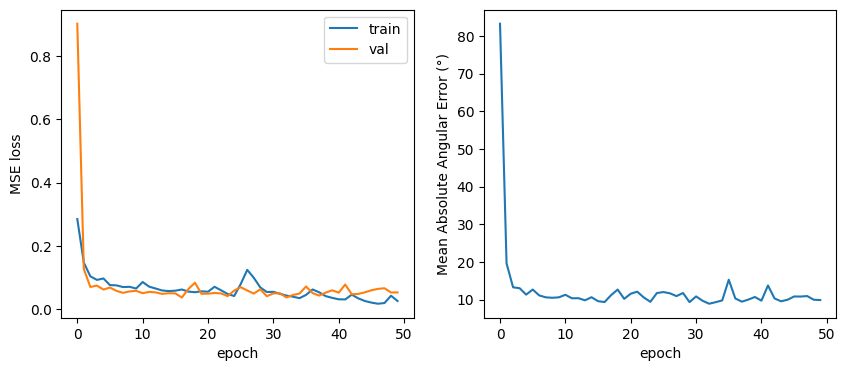

In [12]:
# %% ⸺ (Optional) plot loss + MAAE
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"],   label="val")
plt.xlabel("epoch"); plt.ylabel("MSE loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["val_maae"])
plt.xlabel("epoch"); plt.ylabel("Mean Absolute Angular Error (°)")
plt.show()

In [13]:
# %% ⸺ Save trained weights
# After your training loop finishes:
SAVE_PATH = "angle_cnn_weights.pth"
torch.save(model.state_dict(), SAVE_PATH)
print(f"Saved model weights to {SAVE_PATH}")

Saved model weights to angle_cnn_weights.pth
